In [1]:
import pandas as pd
import numpy as np


from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
import re

from sklearn.model_selection import train_test_split


from imblearn.over_sampling import SMOTE


from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from xgboost import XGBClassifier
from sklearn.svm import SVC

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

import matplotlib.pyplot as plt
import seaborn as sns
import warnings

In [2]:
df = pd.read_csv("train.csv", skipinitialspace = True)

In [3]:
df

,ID,Loan Amount,Funded Amount,Funded Amount Investor,Term,Batch Enrolled,Interest Rate,Grade,Sub Grade,Employment Duration,...,Recoveries,Collection Recovery Fee,Collection 12 months Medical,Application Type,Last week Pay,Accounts Delinquent,Total Collection Amount,Total Current Balance,Total Revolving Credit Limit,Loan Status
0,65087372,10000,32236,12329.36286,59,BAT2522922,11.135007,B,C4,MORTGAGE,...,2.498291,0.793724,0,INDIVIDUAL,49,0,31,311301,6619,0
1,1450153,3609,11940,12191.99692,59,BAT1586599,12.237563,C,D3,RENT,...,2.377215,0.974821,0,INDIVIDUAL,109,0,53,182610,20885,0
2,1969101,28276,9311,21603.22455,59,BAT2136391,12.545884,F,D4,MORTGAGE,...,4.316277,1.020075,0,INDIVIDUAL,66,0,34,89801,26155,0
3,6651430,11170,6954,17877.15585,59,BAT2428731,16.731201,C,C3,MORTGAGE,...,0.107020,0.749971,0,INDIVIDUAL,39,0,40,9189,60214,0
4,14354669,16890,13226,13539.92667,59,BAT5341619,15.008300,C,D4,MORTGAGE,...,1294.818751,0.368953,0,INDIVIDUAL,18,0,430,126029,22579,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67458,16164945,13601,6848,13175.28583,59,BAT3193689,9.408858,C,A4,MORTGAGE,...,564.614852,0.865230,0,INDIVIDUAL,69,0,48,181775,34301,1
67459,35182714,8323,11046,15637.46301,59,BAT1780517,9.972104,C,B3,RENT,...,2.015494,1.403368,0,INDIVIDUAL,14,0,37,22692,8714,0
67460,16435904,15897,32921,12329.45775,59,BAT1761981,19.650943,A,F3,MORTGAGE,...,5.673092,1.607093,0,INDIVIDUAL,137,0,17,176857,42330,0
67461,5300325,16567,4975,21353.68465,59,BAT2333412,13.169095,D,E3,OWN,...,1.157454,0.207608,0,INDIVIDUAL,73,0,61,361339,39075,0


In [4]:
df.drop(columns = ['ID', 'Payment Plan', 'Accounts Delinquent'], axis = 1, inplace = True)

# Note

# Reasons for dropping of features

# 1. ID ---> Identifier
# 2. Payment Plan --->  Contains unique values for each observation.
# 3. Accounts Delinquent ---> Constant variance
# 4. Feature 'ID' has not been dropped from test dataset because it is required there for the submission.

In [5]:
# 1. Encoding Ordinal Categorical variables - Grade

#grade = {"A":1, "B":2, "C":3, "D":4, "E":5, "F":6, "G":7 }

#for dataset in df:
#   dataset['Grade'] = dataset['Grade'].map(grade)

In [6]:
# 2. Encoding Ordinal Categorical variables - Sub Grade

#subgrade = {"A1":1, "A2":2, "A3":3, "A4":4, "A5":5,
 #          "B1":6, "B2":7, "B3":8, "B4":9, "B5":10,
#         "C1":11, "C2":12, "C3":13, "C4":14, "C5":15,
#           "D1":16, "D2":17, "D3":18, "D4":19, "D5":20,
 #          "E1":21, "E2":22, "E3":23, "E4":24, "E5":25,
  #         "F1":26, "F2":27, "F3":28, "F4":29, "F5":30,
  #        "G1":31, "G2":32, "G3":33, "G4":34, "G5":35}

#for dataset in df_combined:
#   dataset['Sub Grade'] = dataset['Sub Grade'].map(subgrade)


In [7]:
df_train_num = df.select_dtypes(include ='number')    #  ---> (67463, 26)
df_train_cat = df.select_dtypes(include = ['object','category'])  # ---> (67463, 9)

df_train_num.shape
df_train_cat.shape
df_train_cat

,Batch Enrolled,Grade,Sub Grade,Employment Duration,Verification Status,Loan Title,Initial List Status,Application Type
0,BAT2522922,B,C4,MORTGAGE,Not Verified,Debt Consolidation,w,INDIVIDUAL
1,BAT1586599,C,D3,RENT,Source Verified,Debt consolidation,f,INDIVIDUAL
2,BAT2136391,F,D4,MORTGAGE,Source Verified,Debt Consolidation,w,INDIVIDUAL
3,BAT2428731,C,C3,MORTGAGE,Source Verified,Debt consolidation,w,INDIVIDUAL
4,BAT5341619,C,D4,MORTGAGE,Source Verified,Credit card refinancing,w,INDIVIDUAL
...,...,...,...,...,...,...,...,...
67458,BAT3193689,C,A4,MORTGAGE,Verified,Credit card refinancing,w,INDIVIDUAL
67459,BAT1780517,C,B3,RENT,Source Verified,Credit card refinancing,w,INDIVIDUAL
67460,BAT1761981,A,F3,MORTGAGE,Verified,Lending loan,w,INDIVIDUAL
67461,BAT2333412,D,E3,OWN,Not Verified,Debt consolidation,f,INDIVIDUAL


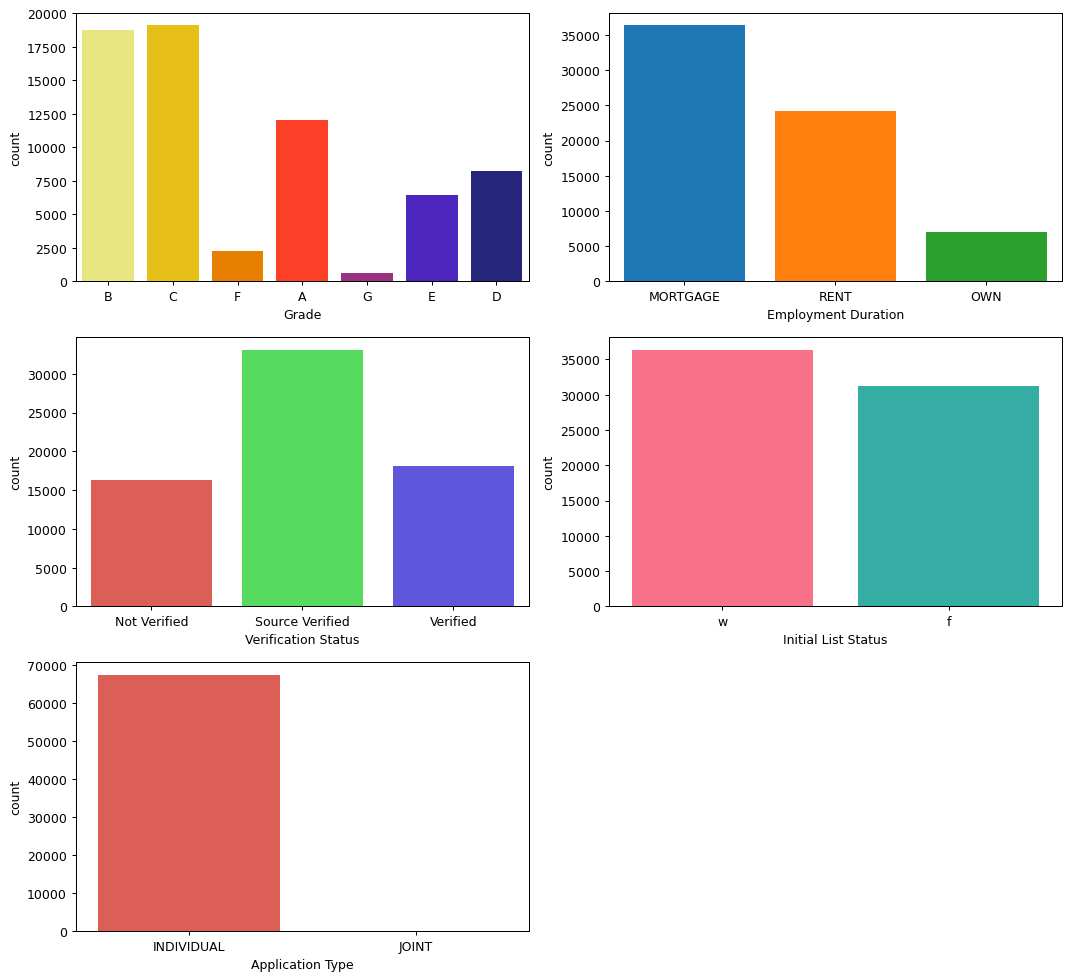

In [8]:
fig, axes = plt.subplots(nrows = 3, ncols = 2, figsize = (12, 11), squeeze = True, dpi = 90)

sns.countplot(data = df_train_cat, x = 'Grade', palette = 'CMRmap_r',saturation = 1,orient = 'h', ax = axes[0,0])
sns.countplot(data = df_train_cat, x = 'Employment Duration', palette = 'tab10', saturation = 1,orient = 'h', ax = axes[0,1])
sns.countplot(data = df_train_cat, x = 'Verification Status', palette = 'hls', saturation = 1,orient = 'h', ax = axes[1,0])
sns.countplot(data = df_train_cat, x = 'Initial List Status', palette = 'husl', saturation = 1,orient = 'h', ax = axes[1,1])
sns.countplot(data = df_train_cat, x = 'Application Type', palette = 'hls', saturation = 1,orient = 'h', ax = axes[2,0])

fig.delaxes(axes[2][1])
fig.tight_layout()

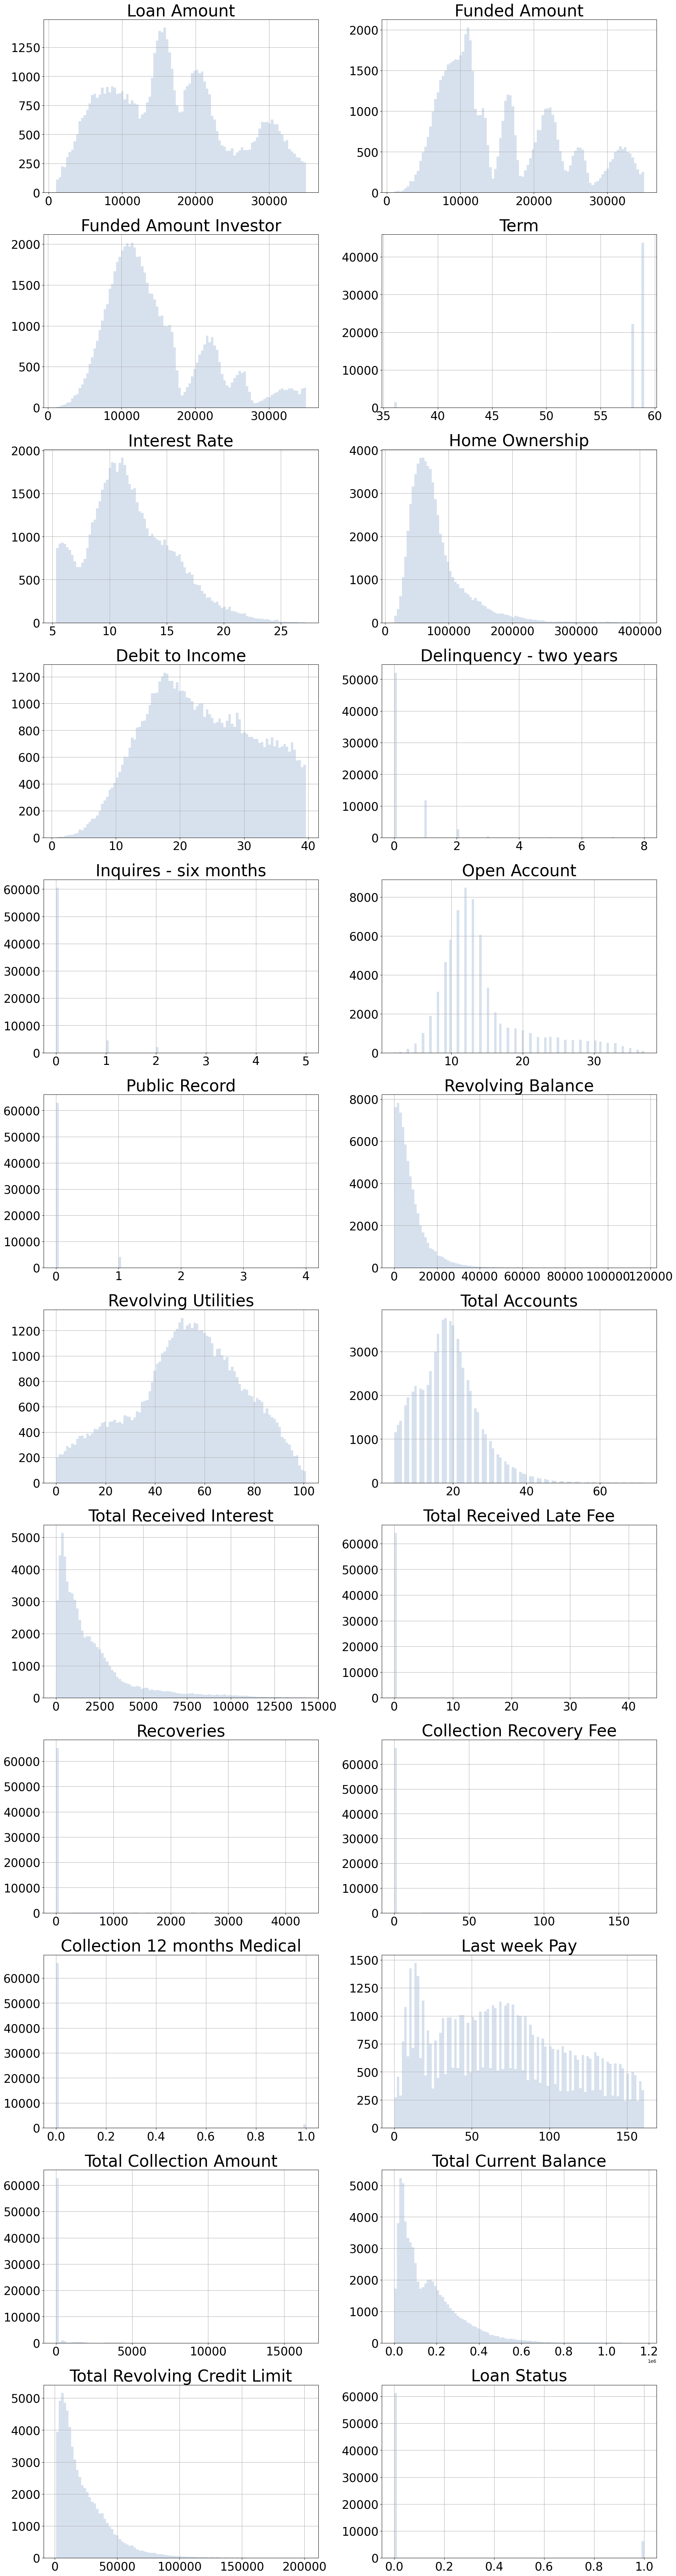

In [9]:
# Plot histogram of numerical variables

def draw_histograms(df_train_num, variables, n_rows, n_cols):
     fig = plt.figure()
     for i, var_name in enumerate(variables):
         ax = fig.add_subplot(n_rows, n_cols, i+1)
         df_train_num[var_name].hist(bins = 100, ax = ax, color = '#B0C4DE', alpha = 0.5, figsize = (20, 90))
         ax.set_title(var_name, fontsize = 35)
         ax.tick_params(axis = 'both', which = 'major', labelsize = 25)
         ax.tick_params(axis = 'both', which = 'minor', labelsize = 25)
         ax.set_xlabel('')
     fig.tight_layout(rect = [0, 0.03, 1, 0.95])    # ---> Enhance appearance
     plt.show()

draw_histograms(df_train_num, df_train_num.columns, 13, 2)

In [10]:
# 3. Encoding Binary Categorical variables - Initial List Status

df.groupby("Initial List Status").size(),

# OR

df["Initial List Status"].value_counts()

w    36299
f    31164
Name: Initial List Status, dtype: int64

In [11]:
df["Initial List Status"].value_counts(normalize = True)

#  OR

freq_train = df["Initial List Status"].value_counts() / df.shape[0]
freq_train

w    0.538058
f    0.461942
Name: Initial List Status, dtype: float64

In [12]:
df["Initial List Status"] = df["Initial List Status"].apply(lambda x : freq_train[x])

In [13]:
# 4. Encoding Binary Categorical variables - Application Type

freq_app_train = df["Application Type"].value_counts(normalize = True)


freq_app_train


INDIVIDUAL    0.998177
JOINT         0.001823
Name: Application Type, dtype: float64

In [14]:
df["Application Type"] = df["Application Type"].apply(lambda x : freq_app_train[x])

In [15]:
# 6. Encoding Nominal Categorical variables - Verification Status (3) (Frequency encoding)


df_train_vs = df["Verification Status"].value_counts(normalize = True).to_dict()
df_train_vs

{'Source Verified': 0.48969064524257744,
 'Verified': 0.2679691089930777,
 'Not Verified': 0.2423402457643449}

In [16]:
df["Verification Status"] = df["Verification Status"].map(df_train_vs)

In [17]:
# 5. Encoding Nominal Categorical variables -  Employment Duration (3) (Frequency encoding)

df_train_ed = df["Employment Duration"].value_counts(normalize = True).to_dict()
df_train_ed

{'MORTGAGE': 0.538828691282629,
 'RENT': 0.3579740005632717,
 'OWN': 0.10319730815409929}

In [18]:
# 7. Encoding Nominal Categorical variables - Loan Title (109) (Frequency encoding)

df_train_lt = df["Loan Title"].value_counts(normalize = True).to_dict()
df_train_lt

{'Credit card refinancing': 0.4554792997643153,
 'Debt consolidation': 0.3682166520907757,
 'Debt Consolidation': 0.05253249929591035,
 'Other': 0.03639031765560381,
 'Home improvement': 0.032773520300016304,
 'Major purchase': 0.007218771771193099,
 'Medical expenses': 0.003513036775714095,
 'Business': 0.0027125980166906303,
 'Moving and relocation': 0.002327201577160814,
 'Car financing': 0.002001096897558662,
 'Vacation': 0.0016898151579384255,
 'debt consolidation': 0.0015564086981011815,
 'Consolidation': 0.0014378251782458532,
 'Home buying': 0.0013933563583001052,
 'Personal Loan': 0.001156189318589449,
 'Debt Consolidation Loan': 0.001052428738716037,
 'Credit Card Consolidation': 0.001007959918770289,
 'Home Improvement': 0.001007959918770289,
 'Consolidate': 0.0008152616990053808,
 'Consolidation Loan': 0.0008152616990053808,
 'consolidation': 0.0007559699390777166,
 'payoff': 0.0007411469990958007,
 'DEBT CONSOLIDATION': 0.0006818552391681366,
 'Green loan': 0.0006670322991

In [19]:
df["Loan Title"] = df["Loan Title"].map(df_train_lt)

In [20]:
# 5. Encoding Nominal Categorical variables -  Employment Duration (3) (Frequency encoding)

df_train_ed = df["Employment Duration"].value_counts(normalize = True).to_dict()
df_train_ed

{'MORTGAGE': 0.538828691282629,
 'RENT': 0.3579740005632717,
 'OWN': 0.10319730815409929}

In [21]:
df["Employment Duration"] = df["Employment Duration"].map(df_train_ed)

In [22]:
#columns_to_drop = ['Batch Enrolled']
columns_to_drop = ['Batch Enrolled','Employment Duration','Grade','Sub Grade']

# Drop the specified columns
df.drop(columns=columns_to_drop, inplace=True)


In [23]:
df

,Loan Amount,Funded Amount,Funded Amount Investor,Term,Interest Rate,Home Ownership,Verification Status,Loan Title,Debit to Income,Delinquency - two years,...,Total Received Late Fee,Recoveries,Collection Recovery Fee,Collection 12 months Medical,Application Type,Last week Pay,Total Collection Amount,Total Current Balance,Total Revolving Credit Limit,Loan Status
0,10000,32236,12329.36286,59,11.135007,176346.62670,0.242340,0.052532,16.284758,1,...,0.102055,2.498291,0.793724,0,0.998177,49,31,311301,6619,0
1,3609,11940,12191.99692,59,12.237563,39833.92100,0.489691,0.368217,15.412409,0,...,0.036181,2.377215,0.974821,0,0.998177,109,53,182610,20885,0
2,28276,9311,21603.22455,59,12.545884,91506.69105,0.489691,0.052532,28.137619,0,...,18.778660,4.316277,1.020075,0,0.998177,66,34,89801,26155,0
3,11170,6954,17877.15585,59,16.731201,108286.57590,0.489691,0.368217,18.043730,1,...,0.044131,0.107020,0.749971,0,0.998177,39,40,9189,60214,0
4,16890,13226,13539.92667,59,15.008300,44234.82545,0.489691,0.455479,17.209886,1,...,19.306646,1294.818751,0.368953,0,0.998177,18,430,126029,22579,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67458,13601,6848,13175.28583,59,9.408858,83961.15003,0.267969,0.455479,28.105127,1,...,0.023478,564.614852,0.865230,0,0.998177,69,48,181775,34301,1
67459,8323,11046,15637.46301,59,9.972104,65491.12817,0.489691,0.455479,17.694279,0,...,0.027095,2.015494,1.403368,0,0.998177,14,37,22692,8714,0
67460,15897,32921,12329.45775,59,19.650943,34813.96985,0.267969,0.000193,10.295774,0,...,0.028212,5.673092,1.607093,0,0.998177,137,17,176857,42330,0
67461,16567,4975,21353.68465,59,13.169095,96938.83564,0.242340,0.368217,7.614624,0,...,0.074508,1.157454,0.207608,0,0.998177,73,61,361339,39075,0


In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67463 entries, 0 to 67462
Data columns (total 28 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Loan Amount                   67463 non-null  int64  
 1   Funded Amount                 67463 non-null  int64  
 2   Funded Amount Investor        67463 non-null  float64
 3   Term                          67463 non-null  int64  
 4   Interest Rate                 67463 non-null  float64
 5   Home Ownership                67463 non-null  float64
 6   Verification Status           67463 non-null  float64
 7   Loan Title                    67463 non-null  float64
 8   Debit to Income               67463 non-null  float64
 9   Delinquency - two years       67463 non-null  int64  
 10  Inquires - six months         67463 non-null  int64  
 11  Open Account                  67463 non-null  int64  
 12  Public Record                 67463 non-null  int64  
 13  R

In [25]:

X = df.drop("Loan Status", axis = 'columns')
y = df["Loan Status"]


X.shape

(67463, 27)

In [26]:
y

0        0
1        0
2        0
3        0
4        0
        ..
67458    1
67459    0
67460    0
67461    0
67462    0
Name: Loan Status, Length: 67463, dtype: int64

In [27]:
print(df.groupby('Loan Status').size())

Loan Status
0    61222
1     6241
dtype: int64


In [28]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=10)
tfid = TfidfVectorizer()
X_final =  tfid.fit_transform(X)
 #Handling imbalanced using SMOTE
smote = SMOTE()
x_sm,y_sm = smote.fit_resample(X,y)
X_train , X_test , y_train , y_test = train_test_split(x_sm , y_sm , test_size=0.2)
print("X_train:" ,X_train.shape, ", y_train: ", len(y_train))
print("X_test: ",X_test.shape, ", y_test: ", len(y_test))

X_train: (97955, 27) , y_train:  97955
X_test:  (24489, 27) , y_test:  24489


In [29]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)
X_train


array([[0.14108751, 0.58645156, 0.72679368, ..., 0.00127893, 0.04961782,
        0.07600249],
       [0.79056082, 0.26625843, 0.5580239 , ..., 0.00213155, 0.13708845,
        0.06493228],
       [0.65694698, 0.24977184, 0.39759716, ..., 0.00158343, 0.27624692,
        0.19080933],
       ...,
       [0.39639852, 0.21308917, 0.35669281, ..., 0.00194884, 0.21678117,
        0.30354083],
       [0.86462073, 0.70038567, 0.39601701, ..., 0.08087698, 0.02460242,
        0.06640083],
       [0.61587124, 0.7045662 , 0.25239161, ..., 0.00170524, 0.46189693,
        0.04472444]])

#Random forest

In [30]:
random_forest_classifier = RandomForestClassifier()
random_forest_classifier.fit(X_train,y_train)

RandomForestClassifier()

In [31]:
random_forest_classifier_prediction =  random_forest_classifier.predict(X_test)

In [32]:
accuracy_score(random_forest_classifier_prediction,y_test)

0.925313406019029

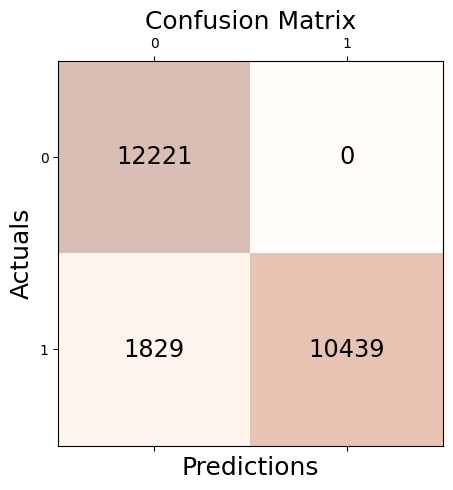

In [33]:
fig, ax = plt.subplots(figsize = (5, 5))
ax.matshow(confusion_matrix(y_test, random_forest_classifier_prediction), cmap = plt.cm.Oranges, alpha = 0.3)
for i in range(confusion_matrix(y_test, random_forest_classifier_prediction).shape[0]):
    for j in range(confusion_matrix(y_test, random_forest_classifier_prediction).shape[1]):
        ax.text(x = j, y = i,s = confusion_matrix(y_test, random_forest_classifier_prediction)[i, j], va = 'center', ha = 'center', size = 'xx-large')

plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [34]:
print(classification_report(y_test,random_forest_classifier_prediction))

              precision    recall  f1-score   support

           0       0.87      1.00      0.93     12221
           1       1.00      0.85      0.92     12268

    accuracy                           0.93     24489
   macro avg       0.93      0.93      0.92     24489
weighted avg       0.94      0.93      0.92     24489



#Decision tree

In [35]:
des_tree_classifier = DecisionTreeClassifier()
des_tree_classifier.fit(X_train,y_train)

DecisionTreeClassifier()

In [36]:
des_tree_classifier_prediction=des_tree_classifier.predict(X_test)

In [37]:
accuracy_score(des_tree_classifier_prediction,y_test)

0.8696965984727837

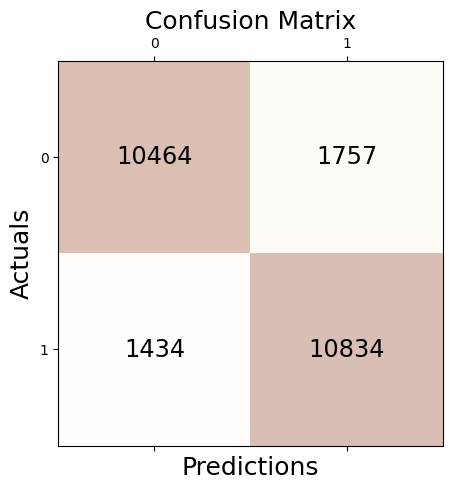

In [38]:
fig, ax = plt.subplots(figsize = (5, 5))
ax.matshow(confusion_matrix(y_test, des_tree_classifier_prediction), cmap = plt.cm.Oranges, alpha = 0.3)
for i in range(confusion_matrix(y_test, des_tree_classifier_prediction).shape[0]):
    for j in range(confusion_matrix(y_test, des_tree_classifier_prediction).shape[1]):
        ax.text(x = j, y = i,s = confusion_matrix(y_test, des_tree_classifier_prediction)[i, j], va = 'center', ha = 'center', size = 'xx-large')

plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [39]:
cr = classification_report(y_test, des_tree_classifier_prediction)
print("Classification Report:\n----------------------\n", cr)

Classification Report:
----------------------
               precision    recall  f1-score   support

           0       0.88      0.86      0.87     12221
           1       0.86      0.88      0.87     12268

    accuracy                           0.87     24489
   macro avg       0.87      0.87      0.87     24489
weighted avg       0.87      0.87      0.87     24489



#Logistic regression

In [40]:
print('Training model (this could take some time)...')
clf = LogisticRegression(solver='lbfgs', multi_class='auto', max_iter=200)
clf.fit(X_train, y_train)

print('Calculating results...')
predictions_train = clf.predict(X_train)
predictions_test = clf.predict(X_test)

accuracy_train = accuracy_score(predictions_train, y_train)
print("Logistic Regression Train accuracy is: {:.4f}".format(accuracy_train))

accuracy_test = accuracy_score(predictions_test, y_test)
print("Logistic Regression Test accuracy is: {:.4f}".format(accuracy_test))

Training model (this could take some time)...
Calculating results...
Logistic Regression Train accuracy is: 0.6005
Logistic Regression Test accuracy is: 0.5981


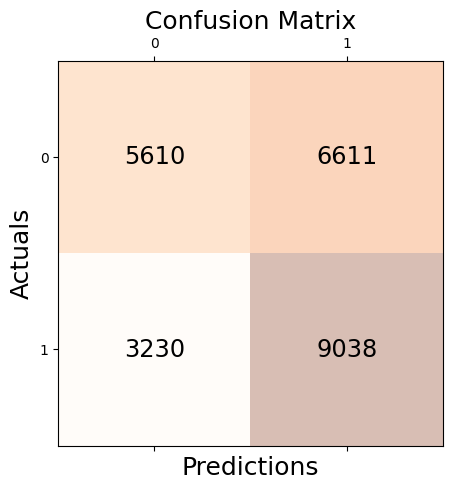

In [41]:
fig, ax = plt.subplots(figsize = (5, 5))
ax.matshow(confusion_matrix(y_test, predictions_test), cmap = plt.cm.Oranges, alpha = 0.3)
for i in range(confusion_matrix(y_test, predictions_test).shape[0]):
    for j in range(confusion_matrix(y_test, predictions_test).shape[1]):
        ax.text(x = j, y = i,s = confusion_matrix(y_test, predictions_test)[i, j], va = 'center', ha = 'center', size = 'xx-large')

plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [42]:
cr = classification_report(y_test, predictions_test)
print("Classification Report:\n----------------------\n", cr)

cm = confusion_matrix(y_test,predictions_test)




Classification Report:
----------------------
               precision    recall  f1-score   support

           0       0.63      0.46      0.53     12221
           1       0.58      0.74      0.65     12268

    accuracy                           0.60     24489
   macro avg       0.61      0.60      0.59     24489
weighted avg       0.61      0.60      0.59     24489



#KNN

In [43]:
from sklearn.neighbors import KNeighborsClassifier


In [44]:
# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

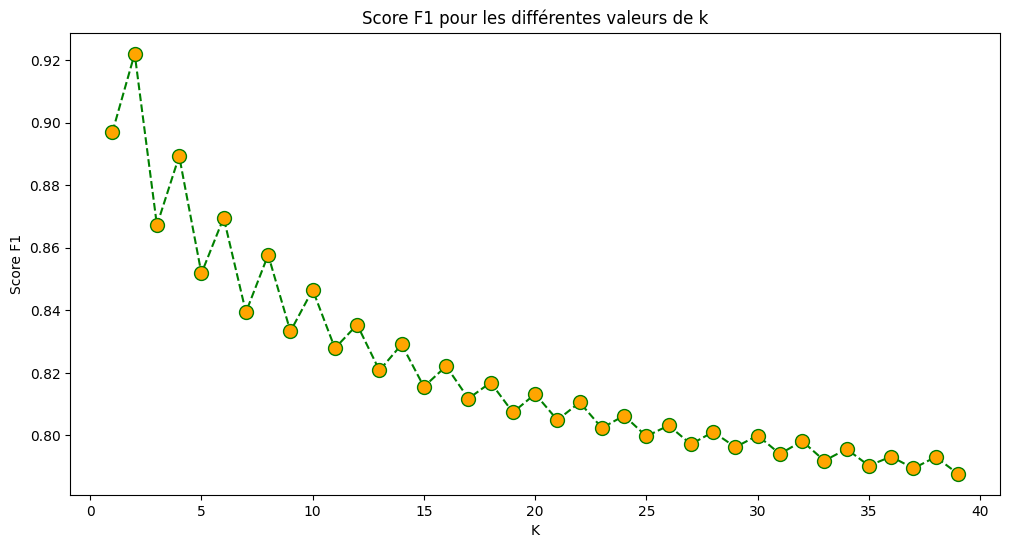

In [45]:
from sklearn.metrics import f1_score
# Initialiser une liste pour stocker les scores F1
f1_scores = []

# Calculer le F1 Score pour k entre 1 et 40
for i in range(1, 40):
    knn = KNeighborsClassifier(i)
    knn_model = knn.fit(X_train, y_train)
    pred_i = knn_model.predict(X_test)

    # Calculer le F1 Score et l'ajouter à la liste
    f1 = f1_score(y_test, pred_i, average='weighted')  # Vous pouvez choisir l'option 'micro', 'macro', ou 'weighted'
    f1_scores.append(f1)

# Tracer le graphique avec les scores F1
plt.figure(figsize=(12, 6))
plt.plot(range(1, 40), f1_scores, color='green', linestyle='dashed', marker='o', markerfacecolor='orange', markersize=10)
plt.title('Score F1 pour les différentes valeurs de k')
plt.xlabel('K')
plt.ylabel('Score F1')
plt.show()

In [46]:
knn = KNeighborsClassifier(2)
knn_model = knn.fit(X_train, y_train)
y_pred_knn =knn_model.predict(X_test)

In [47]:
# print('Accuracy of K-NN classifier on training set: {:.2f}'
#      .format(knn.score(X_train, y_train)))
print('Accuracy of K-NN classifier on test set: {:.2f}'
     .format(knn.score(X_test, y_test)))

Accuracy of K-NN classifier on test set: 0.92


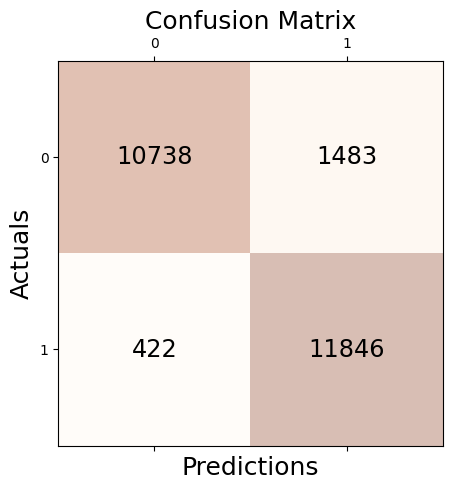

In [48]:
fig, ax = plt.subplots(figsize = (5, 5))
ax.matshow(confusion_matrix(y_test, y_pred_knn), cmap = plt.cm.Oranges, alpha = 0.3)
for i in range(confusion_matrix(y_test,y_pred_knn).shape[0]):
    for j in range(confusion_matrix(y_test,y_pred_knn).shape[1]):
        ax.text(x = j, y = i,s = confusion_matrix(y_test, y_pred_knn)[i, j], va = 'center', ha = 'center', size = 'xx-large')

plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [49]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_knn))

              precision    recall  f1-score   support

           0       0.96      0.88      0.92     12221
           1       0.89      0.97      0.93     12268

    accuracy                           0.92     24489
   macro avg       0.93      0.92      0.92     24489
weighted avg       0.93      0.92      0.92     24489



#XGBoost

In [50]:
xgb = XGBClassifier()
xgb.fit(X_train,y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [51]:
xgb_prediction =  xgb.predict(X_test)

In [52]:
accuracy_score(xgb_prediction,y_test)

0.9158397647923557

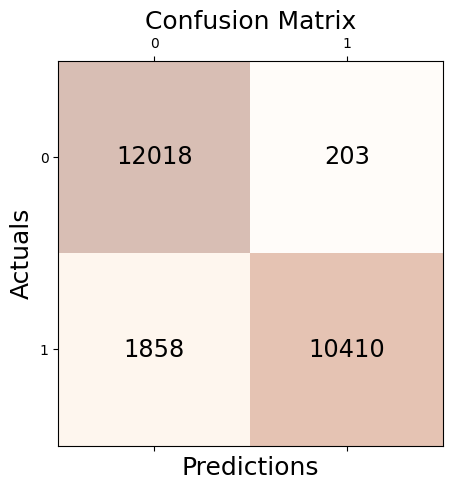

In [53]:
fig, ax = plt.subplots(figsize = (5, 5))
ax.matshow(confusion_matrix(y_test, xgb_prediction), cmap = plt.cm.Oranges, alpha = 0.3)
for i in range(confusion_matrix(y_test,xgb_prediction).shape[0]):
    for j in range(confusion_matrix(y_test,xgb_prediction).shape[1]):
        ax.text(x = j, y = i,s = confusion_matrix(y_test, xgb_prediction)[i, j], va = 'center', ha = 'center', size = 'xx-large')

plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [54]:
from sklearn.metrics import classification_report
print(classification_report(y_test, xgb_prediction))

              precision    recall  f1-score   support

           0       0.87      0.98      0.92     12221
           1       0.98      0.85      0.91     12268

    accuracy                           0.92     24489
   macro avg       0.92      0.92      0.92     24489
weighted avg       0.92      0.92      0.92     24489



#SVM

In [55]:
svm = SVC()
svm.fit(X_train,y_train)

SVC()

In [56]:
svm_prediction =  svm.predict(X_test)

In [57]:
accuracy_score(svm_prediction,y_test)

0.8037894564906692

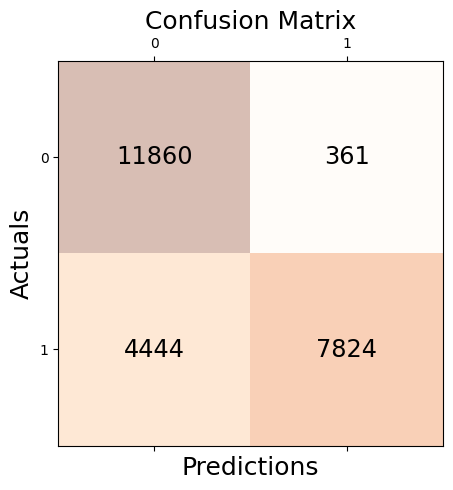

In [58]:
fig, ax = plt.subplots(figsize = (5, 5))
ax.matshow(confusion_matrix(y_test, svm_prediction), cmap = plt.cm.Oranges, alpha = 0.3)
for i in range(confusion_matrix(y_test,svm_prediction).shape[0]):
    for j in range(confusion_matrix(y_test,svm_prediction).shape[1]):
        ax.text(x = j, y = i,s = confusion_matrix(y_test,svm_prediction)[i, j], va = 'center', ha = 'center', size = 'xx-large')

plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [59]:
from sklearn.metrics import classification_report
print(classification_report(y_test, svm_prediction))

              precision    recall  f1-score   support

           0       0.73      0.97      0.83     12221
           1       0.96      0.64      0.77     12268

    accuracy                           0.80     24489
   macro avg       0.84      0.80      0.80     24489
weighted avg       0.84      0.80      0.80     24489



#Naive Bayes

In [60]:
nb = MultinomialNB()
nb.fit(X_train,y_train)

MultinomialNB()

In [61]:
nb_prediction =  nb.predict(X_test)

In [62]:
accuracy_score(nb_prediction,y_test)

0.583608967291437

In [63]:
print(confusion_matrix(y_test,nb_prediction))

[[ 3858  8363]
 [ 1834 10434]]


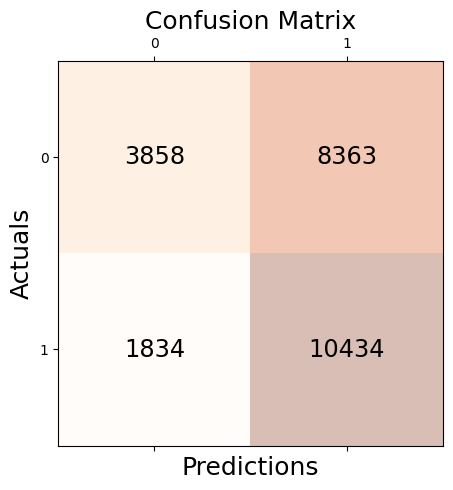

In [64]:
fig, ax = plt.subplots(figsize = (5, 5))
ax.matshow(confusion_matrix(y_test, nb_prediction), cmap = plt.cm.Oranges, alpha = 0.3)
for i in range(confusion_matrix(y_test,nb_prediction).shape[0]):
    for j in range(confusion_matrix(y_test,nb_prediction).shape[1]):
        ax.text(x = j, y = i,s = confusion_matrix(y_test,nb_prediction)[i, j], va = 'center', ha = 'center', size = 'xx-large')

plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [65]:
print(classification_report(y_test,nb_prediction))

              precision    recall  f1-score   support

           0       0.68      0.32      0.43     12221
           1       0.56      0.85      0.67     12268

    accuracy                           0.58     24489
   macro avg       0.62      0.58      0.55     24489
weighted avg       0.62      0.58      0.55     24489



In [66]:
from sklearn.metrics import roc_curve, auc

<ipython-input-67-a155c45ffc2f>:86: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  ax_arr[2,0].plot(fprnb, tprnb, 'b', label = 'Naive Bayes', color='YELLOW')
<ipython-input-67-a155c45ffc2f>:87: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  ax_arr[2,0].plot(fprxgb, tprxgb, 'b', label = 'XGBoost', color='black')
<ipython-input-67-a155c45ffc2f>:88: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  ax_arr[2,0].plot(fprdtree, tprdtree, 'b', label = 'Decision Tree', color='blue')
<ipython-input-67-a155c45ffc2f>:89: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0

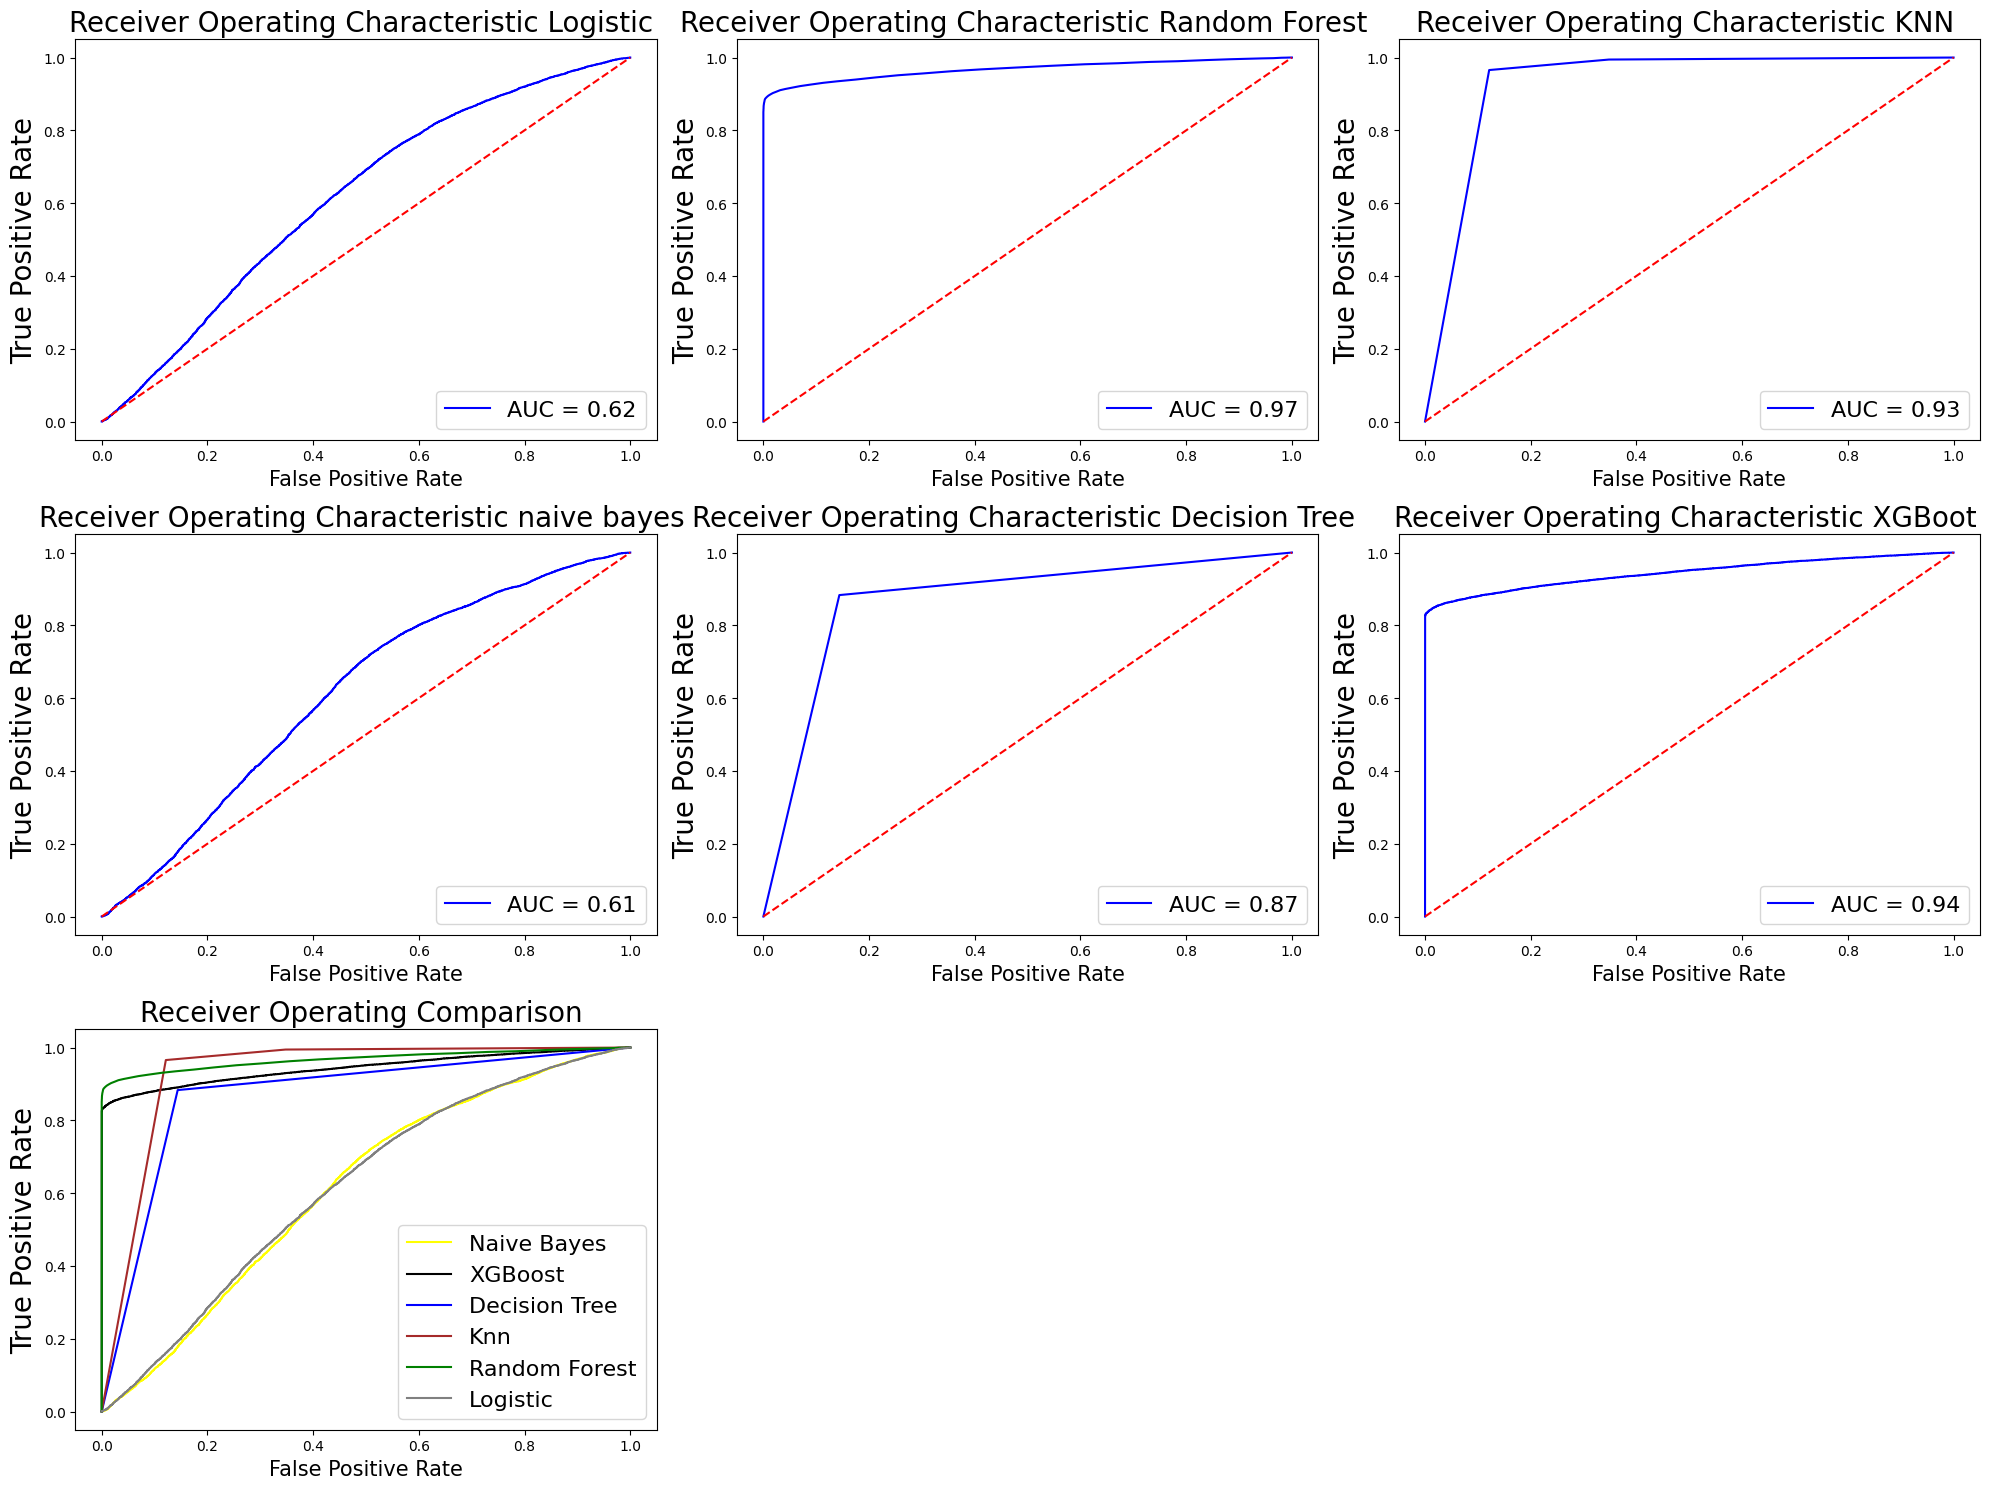

In [67]:
from sklearn import metrics
#fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(nrows = 2, ncols = 3, figsize = (15, 4))
fig, ax_arr = plt.subplots(nrows = 3, ncols = 3, figsize = (20,15))

#LOGMODEL
probs =clf.predict_proba(X_test)
preds = probs[:,1]
fprlog, tprlog, thresholdlog = metrics.roc_curve(y_test, preds)
roc_auclog = metrics.auc(fprlog, tprlog)

ax_arr[0,0].plot(fprlog, tprlog, 'b', label = 'AUC = %0.2f' % roc_auclog)
ax_arr[0,0].plot([0, 1], [0, 1],'r--')
ax_arr[0,0].set_title('Receiver Operating Characteristic Logistic ',fontsize=20)
ax_arr[0,0].set_ylabel('True Positive Rate',fontsize=20)
ax_arr[0,0].set_xlabel('False Positive Rate',fontsize=15)
ax_arr[0,0].legend(loc = 'lower right', prop={'size': 16})

#RANDOM FOREST --------------------
probs = random_forest_classifier.predict_proba(X_test)
preds = probs[:,1]
fprrfc, tprrfc, thresholdrfc = metrics.roc_curve(y_test, preds)
roc_aucrfc = metrics.auc(fprrfc, tprrfc)

ax_arr[0,1].plot(fprrfc, tprrfc, 'b', label = 'AUC = %0.2f' % roc_aucrfc)
ax_arr[0,1].plot([0, 1], [0, 1],'r--')
ax_arr[0,1].set_title('Receiver Operating Characteristic Random Forest ',fontsize=20)
ax_arr[0,1].set_ylabel('True Positive Rate',fontsize=20)
ax_arr[0,1].set_xlabel('False Positive Rate',fontsize=15)
ax_arr[0,1].legend(loc = 'lower right', prop={'size': 16})

#KNN----------------------
probs = knn.predict_proba(X_test)
preds = probs[:,1]
fprknn, tprknn, thresholdknn = metrics.roc_curve(y_test, preds)
roc_aucknn = metrics.auc(fprknn, tprknn)

ax_arr[0,2].plot(fprknn, tprknn, 'b', label = 'AUC = %0.2f' % roc_aucknn)
ax_arr[0,2].plot([0, 1], [0, 1],'r--')
ax_arr[0,2].set_title('Receiver Operating Characteristic KNN ',fontsize=20)
ax_arr[0,2].set_ylabel('True Positive Rate',fontsize=20)
ax_arr[0,2].set_xlabel('False Positive Rate',fontsize=15)
ax_arr[0,2].legend(loc = 'lower right', prop={'size': 16})
#NAIVE---------------------
probs = nb.predict_proba(X_test)
preds = probs[:,1]
fprnb, tprnb, thresholdnb = metrics.roc_curve(y_test, preds)
roc_aucnb = metrics.auc(fprnb, tprnb)

ax_arr[1,0].plot(fprnb, tprnb, 'b', label = 'AUC = %0.2f' % roc_aucnb)
ax_arr[1,0].plot([0, 1], [0, 1],'r--')
ax_arr[1,0].set_title('Receiver Operating Characteristic naive bayes ',fontsize=20)
ax_arr[1,0].set_ylabel('True Positive Rate',fontsize=20)
ax_arr[1,0].set_xlabel('False Positive Rate',fontsize=15)
ax_arr[1,0].legend(loc = 'lower right', prop={'size': 16})
#DECISION TREE ---------------------
probs = des_tree_classifier.predict_proba(X_test)
preds = probs[:,1]
fprdtree, tprdtree, thresholddtree = metrics.roc_curve(y_test, preds)
roc_aucdtree = metrics.auc(fprdtree, tprdtree)

ax_arr[1,1].plot(fprdtree, tprdtree, 'b', label = 'AUC = %0.2f' % roc_aucdtree)
ax_arr[1,1].plot([0, 1], [0, 1],'r--')
ax_arr[1,1].set_title('Receiver Operating Characteristic Decision Tree ',fontsize=20)
ax_arr[1,1].set_ylabel('True Positive Rate',fontsize=20)
ax_arr[1,1].set_xlabel('False Positive Rate',fontsize=15)
ax_arr[1,1].legend(loc = 'lower right', prop={'size': 16})


#XGBoot ---------------------
probs = xgb.predict_proba(X_test)
preds = probs[:,1]
fprxgb, tprxgb, thresholdxgb = metrics.roc_curve(y_test, preds)
roc_aucxgb = metrics.auc(fprxgb, tprxgb)

ax_arr[1,2].plot(fprxgb, tprxgb, 'b', label = 'AUC = %0.2f' % roc_aucxgb)
ax_arr[1,2].plot([0, 1], [0, 1],'r--')
ax_arr[1,2].set_title('Receiver Operating Characteristic XGBoot ',fontsize=20)
ax_arr[1,2].set_ylabel('True Positive Rate',fontsize=20)
ax_arr[1,2].set_xlabel('False Positive Rate',fontsize=15)
ax_arr[1,2].legend(loc = 'lower right', prop={'size': 16})



#ALL PLOTS ----------------------------------
#ax_arr[2,0].plot(fprsvm, tprsvm, 'b', label = 'SVC', color='black')
ax_arr[2,0].plot(fprnb, tprnb, 'b', label = 'Naive Bayes', color='YELLOW')
ax_arr[2,0].plot(fprxgb, tprxgb, 'b', label = 'XGBoost', color='black')
ax_arr[2,0].plot(fprdtree, tprdtree, 'b', label = 'Decision Tree', color='blue')
ax_arr[2,0].plot(fprknn, tprknn, 'b', label = 'Knn', color='brown')
ax_arr[2,0].plot(fprrfc, tprrfc, 'b', label = 'Random Forest', color='green')
ax_arr[2,0].plot(fprlog, tprlog, 'b', label = 'Logistic', color='grey')
ax_arr[2,0].set_title('Receiver Operating Comparison ',fontsize=20)
ax_arr[2,0].set_ylabel('True Positive Rate',fontsize=20)
ax_arr[2,0].set_xlabel('False Positive Rate',fontsize=15)
ax_arr[2,0].legend(loc = 'lower right', prop={'size': 16})
fig.delaxes(ax_arr[2, 2])
fig.delaxes(ax_arr[2, 1])

plt.subplots_adjust(wspace=0.2)
plt.tight_layout()

Cross validation comparaision

In [68]:
from sklearn.model_selection import cross_val_score
model = KNeighborsClassifier(2)

# Effectuer une validation croisée k-fold avec 5 plis
cv_scores = cross_val_score(model, X, y, cv=5, scoring='accuracy')

# Afficher les scores de validation croisée
print("Scores de validation croisée :", cv_scores)
print("Précision moyenne :", cv_scores.mean())

Scores de validation croisée : [0.89972578 0.90024457 0.89928111 0.90023718 0.90149718]
Précision moyenne : 0.9001971649649612


In [69]:
# list of models
from sklearn.model_selection import cross_val_score
models = [LogisticRegression(max_iter=4000), KNeighborsClassifier(), RandomForestClassifier(),DecisionTreeClassifier(),XGBClassifier(),MultinomialNB()]

In [70]:
def compare_models_cross_validation():

  for model in models:

    cv_score = cross_val_score(model, X,y, cv=5)

    mean_accuracy = sum(cv_score)/len(cv_score)

    mean_accuracy = mean_accuracy*100

    mean_accuracy = round(mean_accuracy, 2)

    print('Cross Validation accuracies for ', model, '=  ', cv_score)
    print('Accuracy % of the ', model, mean_accuracy)
    print('----------------------------------------------')

In [71]:
compare_models_cross_validation()

Cross Validation accuracies for  LogisticRegression(max_iter=4000) =   [0.9075076  0.9075076  0.90743348 0.90750074 0.90750074]
Accuracy % of the  LogisticRegression(max_iter=4000) 90.75
----------------------------------------------
Cross Validation accuracies for  KNeighborsClassifier() =   [0.9021715  0.9021715  0.90202327 0.90127483 0.90216425]
Accuracy % of the  KNeighborsClassifier() 90.2
----------------------------------------------
Cross Validation accuracies for  RandomForestClassifier() =   [0.90735937 0.9075076  0.90743348 0.90750074 0.90750074]
Accuracy % of the  RandomForestClassifier() 90.75
----------------------------------------------
Cross Validation accuracies for  DecisionTreeClassifier() =   [0.81923961 0.81531164 0.81998073 0.82011562 0.81789208]
Accuracy % of the  DecisionTreeClassifier() 81.85
----------------------------------------------
Cross Validation accuracies for  XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylev

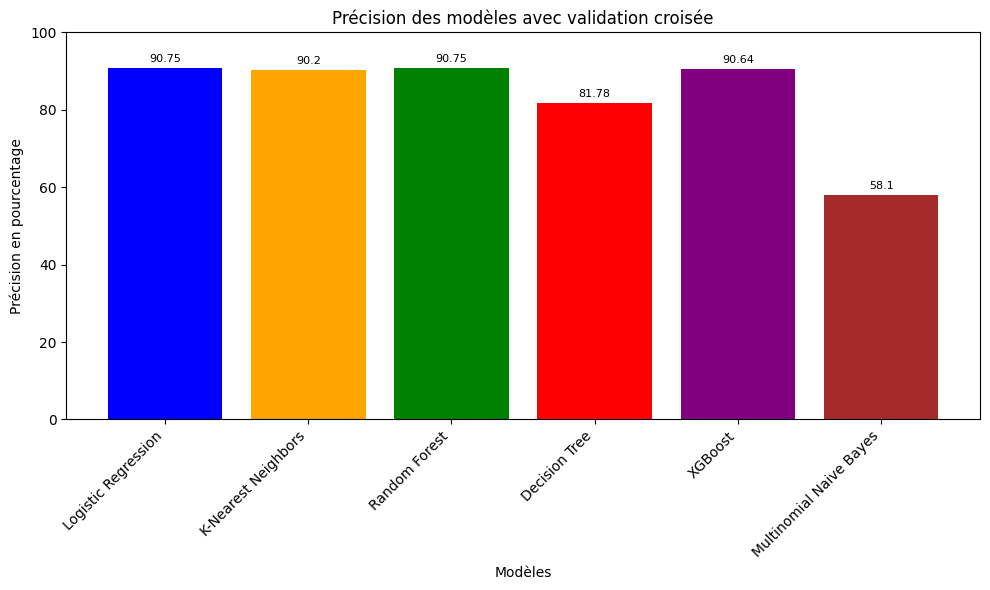

In [72]:
import matplotlib.pyplot as plt

# Définir les noms des modèles
models = ['Logistic Regression', 'K-Nearest Neighbors', 'Random Forest', 'Decision Tree', 'XGBoost', 'Multinomial Naive Bayes']

# Précision moyenne des modèles
accuracies = [90.75, 90.2, 90.75, 81.78, 90.64, 58.1]

# Tracer le graphique à barres
plt.figure(figsize=(10, 6))
bars = plt.bar(models, accuracies, color=['blue', 'orange', 'green', 'red', 'purple', 'brown'])
plt.ylim(0, 100)  # Plage d'axe y de 0 à 100 pour représenter les pourcentages

# Ajouter des étiquettes et des titres
plt.xlabel('Modèles')
plt.ylabel('Précision en pourcentage')
plt.title('Précision des modèles avec validation croisée')
plt.xticks(rotation=45, ha='right')  # Rotation des étiquettes pour une meilleure lisibilité

# Afficher la précision au-dessus des barres
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 1, round(yval, 2), ha='center', va='bottom', fontsize=8)

# Afficher le graphique
plt.tight_layout()
plt.show()


#Conclusion:

In this analysis, we evaluated several classification models using cross-validation with different evaluation metrics. Here is a summary of the results obtained for each model:

**1. Logistic Regression:**
Logistic Regression demonstrated strong performance with an average accuracy of 90.75% across five-fold cross-validation. This suggests that the model is capable of generalizing effectively to new data.

**2. K-Nearest Neighbors (KNN):**
The KNN model also showed good performance with an average accuracy of 90.2%. However, it is slightly lower than logistic regression in this context.

**3. Random Forest:**
The Random Forest model displayed an average accuracy of 90.75%, equal to logistic regression. This indicates that random forests are competitive in this particular problem.

**4. Decision Tree:**
The Decision Tree model showed relatively lower performance with an average accuracy of 81.78%. This could indicate a tendency for overfitting or a particular sensitivity of decision trees to certain data.

**5. XGBoost:**
XGBoost, a boosting model, achieved an average accuracy of 90.64%, placing it between the performance of logistic regression and KNN.

**6. Multinomial Naive Bayes:**
The Naive Bayes model exhibited the lowest performance among the evaluated models, with an average accuracy of 58.1%. This could be due to inappropriate assumptions in the context of specific data.

***Conclusion***
In conclusion, logistic regression and Random Forest appear to be the most performant choices for this particular problem, while the Decision Tree model showed relatively lower performance. However, it is essential to consider other aspects such as training time, model complexity, and the ability to handle large amounts of data in the final model selection.